In [1]:
# Import all required libraries
import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

# Set matplotlib to display plots inline
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "data"
OUTPUT_DIR = NOTEBOOK_DIR / "outputs"

DATA_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Data directory: {DATA_DIR}")

Notebook directory: /notebooks/ml2025
Data directory: /notebooks/ml2025/data


In [3]:
# Find CSV files
patterns = [
    str(DATA_DIR / "AuctionPrice_*_DayAhead_FI_EUR_*.csv"),
    str(DATA_DIR / "AuctionPrice*.csv"),
    str(DATA_DIR / "*.csv")
]

files = []
for pattern in patterns:
    found_files = sorted(glob.glob(pattern))
    if found_files:
        files = found_files
        print(f"Found files using pattern: {pattern}")
        break

if not files:
    print("❌ No CSV files found! Please make sure your files are in the data/ folder.")
    print("Expected files: AuctionPrice_2020_DayAhead_FI_EUR_None.csv, etc.")
else:
    print("✅ Found files:")
    for f in files:
        print(f"  - {os.path.basename(f)}")

# Load Nord Pool files with semicolon delimiter
dfs = []
for f in files:
    try:
        # Nord Pool specific format: semicolon delimiter, European date format
        df = pd.read_csv(f, delimiter=';', encoding='utf-8')
        
        # Clean column names (remove spaces and special characters)
        df.columns = df.columns.str.strip()
        
        df["_source_file"] = os.path.basename(f)
        dfs.append(df)
        print(f"✅ Successfully loaded: {os.path.basename(f)}")
        print(f"   Columns: {list(df.columns)}")
        print(f"   Shape: {df.shape}")
        
    except Exception as e:
        print(f"❌ Failed to load {os.path.basename(f)}: {e}")
        # Try alternative encoding if UTF-8 fails
        try:
            df = pd.read_csv(f, delimiter=';', encoding='latin-1')
            df.columns = df.columns.str.strip()
            df["_source_file"] = os.path.basename(f)
            dfs.append(df)
            print(f"✅ Successfully loaded with latin-1 encoding: {os.path.basename(f)}")
        except Exception as e2:
            print(f"❌ Also failed with latin-1: {e2}")

if not dfs:
    raise SystemExit("No readable files found.")

# Combine all dataframes
combined = pd.concat(dfs, ignore_index=True, sort=False)
print(f"\n✅ Combined {len(dfs)} files with {len(combined)} rows total")
print(f"Final columns: {list(combined.columns)}")

# Display sample data
print("\n📊 Sample data:")
display(combined.head(3))

Found files using pattern: /notebooks/ml2025/data/AuctionPrice_*_DayAhead_FI_EUR_*.csv
✅ Found files:
  - AuctionPrice_2020_DayAhead_FI_EUR_None.csv
  - AuctionPrice_2021_DayAhead_FI_EUR_None.csv
  - AuctionPrice_2022_DayAhead_FI_EUR_None.csv
  - AuctionPrice_2023_DayAhead_FI_EUR_None.csv
  - AuctionPrice_2024_DayAhead_FI_EUR_None.csv
✅ Successfully loaded: AuctionPrice_2020_DayAhead_FI_EUR_None.csv
   Columns: ['Delivery Start (EET)', 'Delivery End (EET)', 'FI Price (EUR)', '_source_file']
   Shape: (8784, 4)
✅ Successfully loaded: AuctionPrice_2021_DayAhead_FI_EUR_None.csv
   Columns: ['Delivery Start (EET)', 'Delivery End (EET)', 'FI Price (EUR)', '_source_file']
   Shape: (8760, 4)
✅ Successfully loaded: AuctionPrice_2022_DayAhead_FI_EUR_None.csv
   Columns: ['Delivery Start (EET)', 'Delivery End (EET)', 'FI Price (EUR)', '_source_file']
   Shape: (8760, 4)
✅ Successfully loaded: AuctionPrice_2023_DayAhead_FI_EUR_None.csv
   Columns: ['Delivery Start (EET)', 'Delivery End (EET)', '

,Delivery Start (EET),Delivery End (EET),FI Price (EUR),_source_file
0,01.01.2020 01:00:00,01.01.2020 02:00:00,28.78,AuctionPrice_2020_DayAhead_FI_EUR_None.csv
1,01.01.2020 02:00:00,01.01.2020 03:00:00,28.45,AuctionPrice_2020_DayAhead_FI_EUR_None.csv
2,01.01.2020 03:00:00,01.01.2020 04:00:00,27.90,AuctionPrice_2020_DayAhead_FI_EUR_None.csv


In [4]:
print("📊 Data Overview:")
print(f"Total rows: {len(combined)}")
print(f"Columns: {list(combined.columns)}")
print("\nFirst 5 rows:")
display(combined.head())

📊 Data Overview:
Total rows: 43848
Columns: ['Delivery Start (EET)', 'Delivery End (EET)', 'FI Price (EUR)', '_source_file']

First 5 rows:


,Delivery Start (EET),Delivery End (EET),FI Price (EUR),_source_file
0,01.01.2020 01:00:00,01.01.2020 02:00:00,28.78,AuctionPrice_2020_DayAhead_FI_EUR_None.csv
1,01.01.2020 02:00:00,01.01.2020 03:00:00,28.45,AuctionPrice_2020_DayAhead_FI_EUR_None.csv
2,01.01.2020 03:00:00,01.01.2020 04:00:00,27.90,AuctionPrice_2020_DayAhead_FI_EUR_None.csv
3,01.01.2020 04:00:00,01.01.2020 05:00:00,27.52,AuctionPrice_2020_DayAhead_FI_EUR_None.csv
4,01.01.2020 05:00:00,01.01.2020 06:00:00,27.54,AuctionPrice_2020_DayAhead_FI_EUR_None.csv


In [5]:
# For Nord Pool data, we know the expected columns
print("Nord Pool columns detected:", list(combined.columns))

# Map Nord Pool columns to our expected names
column_mapping = {
    'Delivery Start (EET)': 'timestamp',
    'Delivery Start (EET)': 'timestamp',  # Primary timestamp column
    'FI Price (EUR)': 'price',
    'Price (EUR)': 'price',
    'FI': 'price',
    'Value': 'price'
}

# Find the best matches
timestamp_col = None
price_col = None

for nord_pool_col, our_col in column_mapping.items():
    if nord_pool_col in combined.columns:
        if our_col == 'timestamp' and timestamp_col is None:
            timestamp_col = nord_pool_col
        elif our_col == 'price' and price_col is None:
            price_col = nord_pool_col

# Fallback: use first column that contains 'start' or 'delivery' for timestamp
if timestamp_col is None:
    for col in combined.columns:
        if 'start' in col.lower() or 'delivery' in col.lower():
            timestamp_col = col
            break

# Fallback: use first column that contains 'price', 'eur', or 'fi' for price
if price_col is None:
    for col in combined.columns:
        if any(keyword in col.lower() for keyword in ['price', 'eur', 'fi', 'value']):
            price_col = col
            break

print(f"Using timestamp column: {timestamp_col}")
print(f"Using price column: {price_col}")

if timestamp_col is None or price_col is None:
    raise ValueError(
        f"Could not detect required columns.\nAvailable columns: {list(combined.columns)}\n"
        "Please check your CSV files and adjust the column mapping."
    )

# Create working dataframe
df = combined[[timestamp_col, price_col]].copy()
df.columns = ['timestamp', 'price']
print("✅ Created working dataframe")

Nord Pool columns detected: ['Delivery Start (EET)', 'Delivery End (EET)', 'FI Price (EUR)', '_source_file']
Using timestamp column: Delivery Start (EET)
Using price column: FI Price (EUR)
✅ Created working dataframe


In [8]:
# Nord Pool uses European date format: DD.MM.YYYY HH:MM:SS
print("Original timestamp format samples:")
print(df['timestamp'].head(3).values)

# Parse Nord Pool timestamp format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d.%m.%Y %H:%M:%S', errors='coerce')

# Check for parsing issues
nan_count = df['timestamp'].isna().sum()
if nan_count > 0:
    print(f"⚠️  Warning: {nan_count} timestamp parsing failures")
    # Show samples that failed to parse
    failed_samples = df[df['timestamp'].isna()]['timestamp'].head(3)
    print("Failed samples:", failed_samples.values)
else:
    print("✅ All timestamps parsed successfully")

# Remove rows with invalid data
initial_count = len(df)
df = df.dropna().reset_index(drop=True)
final_count = len(df)
print(f"Removed {initial_count - final_count} rows with invalid data")

# Sort by timestamp and set hourly frequency
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"Final dataset: {len(df)} rows")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Display cleaned data
print("\n📊 Cleaned data sample:")
display(df.head(3))

Original timestamp format samples:
['2020-01-01T01:00:00.000000000' '2020-01-01T02:00:00.000000000'
 '2020-01-01T03:00:00.000000000']
✅ All timestamps parsed successfully
Removed 0 rows with invalid data
Final dataset: 43848 rows
Date range: 2020-01-01 01:00:00 to 2025-01-01 00:00:00

📊 Cleaned data sample:


,timestamp,price
0,2020-01-01 01:00:00,28.78
1,2020-01-01 02:00:00,28.45
2,2020-01-01 03:00:00,27.90


In [9]:
# Create features
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday
df['month'] = df['timestamp'].dt.month
df['lag_1'] = df['price'].shift(1)
df['lag_24'] = df['price'].shift(24)
df['lag_168'] = df['price'].shift(168)

# Remove rows with missing values from lag features
df = df.dropna().reset_index(drop=True)

# Filter to 2020-2024
df = df[(df['timestamp'].dt.year >= 2020) & (df['timestamp'].dt.year <= 2024)]

print(f"Final dataset size: {len(df)} rows")
print("✅ Feature engineering completed")

# Save cleaned data
df.to_csv(OUTPUT_DIR / "cleaned_features.csv", index=False)
print("💾 Saved cleaned_features.csv")

Final dataset size: 43679 rows
✅ Feature engineering completed
💾 Saved cleaned_features.csv


In [10]:
# Split data
train_df = df[df['timestamp'].dt.year <= 2023]
val_df = df[df['timestamp'].dt.year == 2024]

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Prepare features
features = ['hour', 'weekday', 'month', 'lag_1', 'lag_24', 'lag_168']
X_train = train_df[features]
y_train = train_df['price']
X_val = val_df[features]
y_val = val_df['price']

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_val)

print("✅ Model training completed")

Training samples: 34895
Validation samples: 8784
✅ Model training completed


In [11]:
# Calculate metrics
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)

print("📈 Model Performance:")
print(f"MAE: {mae:.3f} €/MWh")
print(f"RMSE: {rmse:.3f} €/MWh")

# Save metrics
with open(OUTPUT_DIR / "metrics.txt", "w") as f:
    f.write(f"Validation MAE: {mae:.3f} €/MWh\n")
    f.write(f"Validation RMSE: {rmse:.3f} €/MWh\n")
    f.write(f"Train samples: {len(train_df)}\n")
    f.write(f"Validation samples: {len(val_df)}\n")

print("💾 Saved metrics.txt")

📈 Model Performance:
MAE: 10.136 €/MWh
RMSE: 25.685 €/MWh
💾 Saved metrics.txt


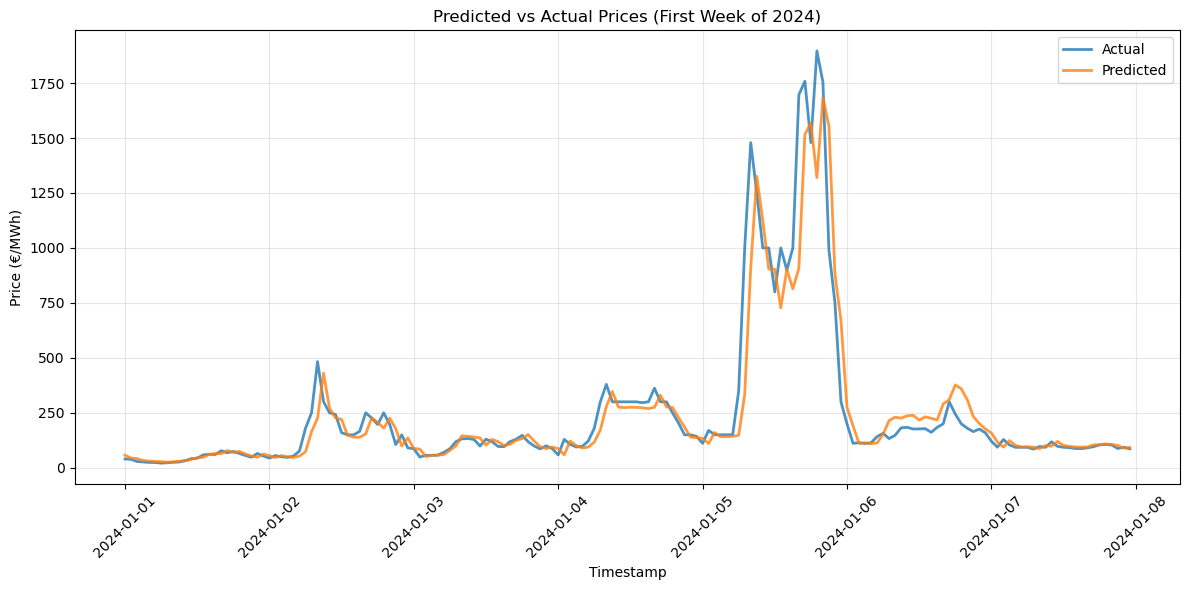

💾 Saved pred_vs_actual_week.png


In [12]:
# Create prediction vs actual plot
plt.figure(figsize=(12, 6))

# Show first week of predictions
n_show = min(168, len(val_df))  # One week

plt.plot(val_df['timestamp'].iloc[:n_show], val_df['price'].iloc[:n_show], 
         label='Actual', linewidth=2, alpha=0.8)
plt.plot(val_df['timestamp'].iloc[:n_show], y_pred[:n_show], 
         label='Predicted', linewidth=2, alpha=0.8)

plt.xlabel('Timestamp')
plt.ylabel('Price (€/MWh)')
plt.title('Predicted vs Actual Prices (First Week of 2024)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plt.savefig(OUTPUT_DIR / "pred_vs_actual_week.png", dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved pred_vs_actual_week.png")

In [13]:
print("🎉 Analysis Complete!")
print(f"Output files saved to: {OUTPUT_DIR}")
print("Files created:")
for file in OUTPUT_DIR.iterdir():
    print(f"  - {file.name}")

# Show feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\n📊 Feature Importance:")
display(feature_importance)

🎉 Analysis Complete!
Output files saved to: /notebooks/ml2025/outputs
Files created:
  - cleaned_features.csv
  - metrics.txt
  - pred_vs_actual_week.png

📊 Feature Importance:


,feature,coefficient
3,lag_1,0.879888
1,weekday,-0.521824
0,hour,-0.213429
4,lag_24,0.075654
5,lag_168,0.042380
2,month,-0.016719
